## The Hodgkin-Huxley model and its formalism

The Hodgkin-Huxley formalism is a very powerful description of how action potentials are generated in neurons.

At its simplest, it models a patch of cell membrane using the following circuit:

<img src="HHcircuit.png" width="400px"/>

The dynamics of the membrane potential $V_m$ are described by a differential equation with the following form:

$C_m \frac{\mathrm{d}V_m}{\mathrm{d}t} = g_L(E_L-V_m) + g_{Na}(t)(E_{Na}-V_m) + g_K(t)(E_K-V_m) + I_{app}$,

where $C_m$ is the membrane capacitance and $I_app$ is an externally applied current. Apart from the leak conductance, which is characterized by a constant $g_L$, each ionic current has the form:

$I(t) = \bar{g} x^p y^q (E - V_m)$,

where $E$ is the reversal potential, $\bar{g}$ is the __maximal__ conductance (i.e., the one that would be observed if all the channels were open), and $x$ and $y$ are so-called __gating variables__. These obey first-order differential equations of the form

$\frac{\mathrm{d}z}{\mathrm{d}t} = \frac{z_\infty(V_m) - z}{\tau_z(V_m)}$,

with $z=\{x,y\}$ and $p,q \in \mathbb{N}$. <br/>
The functions $z_\infty(V_m)$ and $\tau_z(V_m)$ represent the _steady-state_ and _time constant_ of the $z$ gating variable for a certain value of $V_m$ and are given by:

$
z_\infty(V_m) = \frac{\alpha(V_m)}{\alpha(V_m) + \beta(V_m)} \\
\tau_z(V_m) = \frac{1}{\alpha(V_m) + \beta(V_m)},
$

where the functions $\alpha(V_m)$ and $\beta(V_m)$ are called __rate functions__ and are a measure of the rate with which a given ion channel transitions from the open to the closed state and vice versa.

For the specific case of the original HH model, the sodium and potassium currents are written as

$
I_{\mathrm{Na}} = \bar{g}_{\mathrm{Na}} m^3 h (E_{\mathrm{Na}} - V_m) \\
I_{\mathrm{K}}  =  \bar{g}_{\mathrm{K}} n^4   (E_{\mathrm{K}}  - V_m)
$

with rate functions given by

$
\alpha_m(V_m) = 0.1\frac{V_m+40}{1-\exp(-(V_m+40)/10)} \\
\beta_m(V_m) = 4\exp(-(V_m+65)/18) \\
\alpha_h(V_m) = 0.1 \exp(-0.05(V_m+65)) \\
\beta_h(V_m) = \frac{1}{1+\exp(-(V_m+35)/10)} \\
\alpha_n(V_m) = 0.01\frac{V_m+55}{1-\exp(-(V_m+55)/10)} \\
\beta_n(V_m) = 0.125\exp(-(V_m+65)/80)
$

### Gating variables as Markov schemes

A qualitative interpretation of the exponents $p$ and $q$ in the equations of the ionic current is that each gating variable can be in one of the states of a Markov chain with a total of $p+1$-by-$q+1$ possible states, as shown below for the potassium and sodium channels:

<img src="potassium_markov_chain.png" width="450px"/>

<img src="sodium_markov_chain.png" width="400px"/>

When using this abstraction, the only _open_ state, that is, one that is associated to a positive conductance, is the state $n_4$ for potassium and $m_3 h_1$ for sodium.

See [this page](https://neuronaldynamics.epfl.ch/online/Ch2.S2.html) for more details on the HH model.

### A simple analysis of the HH model and its firing properties

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import seaborn as sns

First of all, we define a couple of functions that will be used in the following:

In [2]:
# this avoids problems when the rate function is 0/0
def vtrap(x,y):
    if np.isscalar(x):
        return y*(1-x/y/2) if abs(x/y)<1e-6 else x/(np.exp(x/y) - 1)
    z = np.zeros_like(x, dtype=float)
    idx = abs(x/y) < 1e-6
    z[idx] = y*(1-x[idx]/y/2)
    np.logical_not(idx, out=idx)
    z[idx] = x[idx]/(np.exp(x[idx]/y) - 1)
    return z

# returns x_ss and tau_x
def coeffs(v, alpha_fun, beta_fun):
    a,b = alpha_fun(v),beta_fun(v)
    return a/(a+b), 1/(a+b)

Let's define the rate functions of the HH model:

In [3]:
hh_alphah = lambda v: 0.07 * np.exp(-(v+65)/20)
hh_alpham = lambda v: 0.1 * vtrap(-(v+40), 10)
hh_alphan = lambda v: 0.01 * vtrap(-(v+55), 10)
hh_betah  = lambda v: 1 / (1 + np.exp(-(v+35)/10))
hh_betam  = lambda v: 4 * np.exp(-(v+65)/18)
hh_betan  = lambda v: 0.125 * np.exp(-(v+65)/80)

Let's look at the steady-state and time constant functions:

In [4]:
Vm = np.r_[-100 : 50]
minf,taum = coeffs(Vm, hh_alpham, hh_betam)
hinf,tauh = coeffs(Vm, hh_alphah, hh_betah)
ninf,taun = coeffs(Vm, hh_alphan, hh_betan)

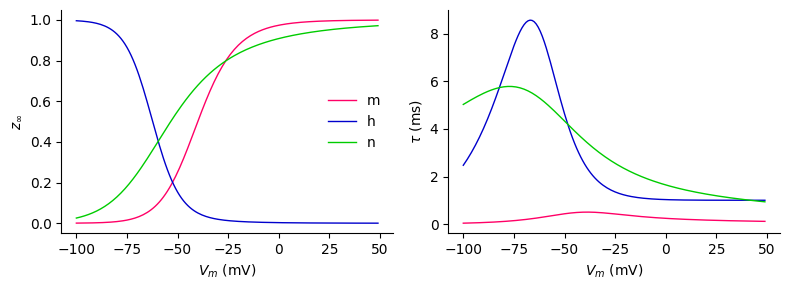

In [5]:
fig,ax = plt.subplots(1, 2, figsize=(8,3), sharex=True)
cmap = {'m': [1,0,.4], 'n': [0,.8,0], 'h': [0,0,.8]}
ax[0].plot(Vm, minf, color=cmap['m'], lw=1, label='m')
ax[0].plot(Vm, hinf, color=cmap['h'], lw=1, label='h')
ax[0].plot(Vm, ninf, color=cmap['n'], lw=1, label='n')
ax[1].plot(Vm, taum, color=cmap['m'], lw=1)
ax[1].plot(Vm, tauh, color=cmap['h'], lw=1)
ax[1].plot(Vm, taun, color=cmap['n'], lw=1)
ax[0].legend(loc='right', frameon=False)
for a in ax:
    a.set_xlabel(r'$V_m$ (mV)')
ax[0].set_ylabel(r'$z_\infty$')
ax[1].set_ylabel(r'$\tau$ (ms)')
sns.despine()
fig.tight_layout()

And now the vector field:

In [6]:
def HH(t,x,I):
    C      =   1   # [μF/cm2]
    ENa    =  55   # [mV]
    EK     = -77   # [mV]
    EL     = -65   # [mV]
    gNabar =  40   # [mS/cm2]
    gKbar  =   3   # [mS/cm2]
    gL     =   0.3 # [mS/cm2]
    f = np.zeros(4)
    v,m,h,n = x
    minf,taum = coeffs(v, hh_alpham, hh_betam)
    hinf,tauh = coeffs(v, hh_alphah, hh_betah)
    ninf,taun = coeffs(v, hh_alphan, hh_betan)
    f[0] = (gL*(EL-v) + gNabar*m**3*h*(ENa-v) + gKbar*n**4*(EK-v) + I) / C
    f[1] = (minf-m)/taum
    f[2] = (hinf-h)/tauh
    f[3] = (ninf-n)/taun
    return f

Let's integrate the system for a specific value of current and let's see what the spiking looks like:

In [7]:
I = 1.2
tspan = [0,200]
Vm0 = -65
minf,_ = coeffs(Vm0, hh_alpham, hh_betam)
hinf,_ = coeffs(Vm0, hh_alphah, hh_betah)
ninf,_ = coeffs(Vm0, hh_alphan, hh_betan)
x0 = [Vm0, minf, hinf, ninf]
sol = solve_ivp(HH, tspan, x0, method='BDF', args=(I,), rtol=1e-6, atol=1e-8)

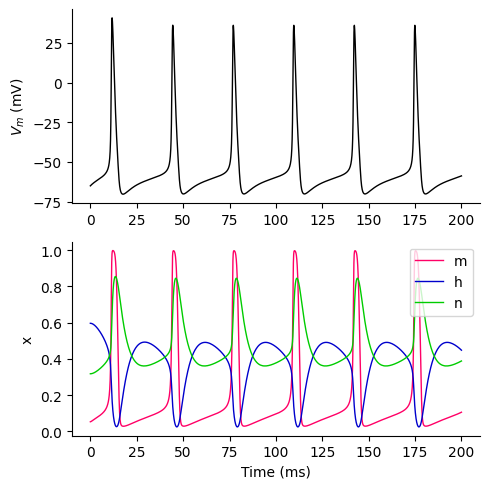

In [8]:
fig,ax = plt.subplots(2, 1, figsize=(5,5))
ax[0].plot(sol.t, sol.y[0], 'k', lw=1)
ax[0].set_ylabel(r'$V_m$ (mV)')
for i,var_name in enumerate('mhn'):
    ax[1].plot(sol.t, sol.y[i+1], color=cmap[var_name], lw=1, label=var_name)
ax[1].set_ylabel('x')
ax[1].legend(loc='best')
ax[-1].set_xlabel('Time (ms)')
sns.despine()
fig.tight_layout()

### Current-frequency relationship in the HH model

In [9]:
from scipy.signal import find_peaks
from tqdm.notebook import tqdm

In [10]:
def measure_firing_rate(Iapp, tend=500, ttran=100):
    Vm0 = -65
    minf,_ = coeffs(Vm0, hh_alpham, hh_betam)
    hinf,_ = coeffs(Vm0, hh_alphah, hh_betah)
    ninf,_ = coeffs(Vm0, hh_alphan, hh_betan)
    x0 = [Vm0, minf, hinf, ninf]
    sol = solve_ivp(HH, [0,tend], x0, method='BDF', args=(Iapp,), rtol=1e-6, atol=1e-8)
    idx, = np.where(sol.t > ttran)
    Vm = sol.y[0,idx]
    pks,_ = find_peaks(Vm, height=0)
    return 1000/np.diff(sol.t[idx[pks[-2:]]]) if pks.size >= 2 else 0

In [11]:
I_min,I_max,n_I = 0, 3, 100
I = np.linspace(I_min, I_max, n_I)
f = np.zeros_like(I, dtype=float)
for k in tqdm(range(n_I)):
    f[k] = measure_firing_rate(I[k])

  0%|          | 0/100 [00:00<?, ?it/s]

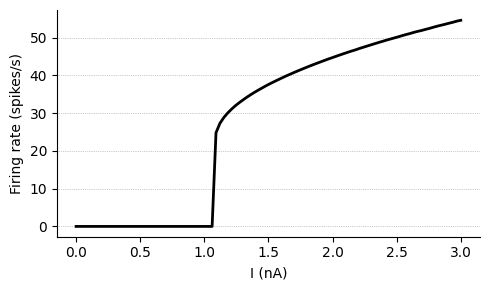

In [12]:
fig,ax = plt.subplots(1, 1, figsize=(5,3))
ax.plot(I, f, 'k', lw=2)
ax.set_xlabel('I (nA)')
ax.set_ylabel('Firing rate (spikes/s)')
ax.grid(which='major', axis='y', ls=':', lw=0.5, color=[.6,.6,.6])
sns.despine()
fig.tight_layout()